## Goals

Given the images, text, and audio files, as well as machine learning outputs, your goal is to identify, use data analytics to answer the questions below. Your tasks is to use visual analytics to improve and understand machine learning outputs and apply visual analytics to track provenance, uncertainty, and confidence in machine learning results. Ultimately, you must link multiple data types to identify the group CGCS is seeking.

    1. Examine the outputs from the model – either from the detection results provided or the results from a model you chose. Which objects were identified well by the model and which were not?

    2. Demonstrate your process for using visual analytics to correct for classification errors in the results. How do you represent confidence and uncertainty? How could the correction process be made more efficient?

    3. Characterize the distribution of objects across the forty people.

        a. Which people have which objects?

        b. Identify groups of people that have object(s) in common.

    4. Which group do you think is the most likely group with the “totem”? What is your rationale for that assessment?

    5. Process question: Did you choose to use the object recognition model results provided or use your own machine learning algorithm? Why did you make that choice? What was the biggest challenge you faced?

In [61]:
import os
import re
import subprocess
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Command used to train YOLOv7 object detection model on custom training data.
%run train.py --epochs 100 --workers 4 --batch-size 4 --data data/custom.yaml --cfg cfg/training/yolov7.yaml --weights yolov7_training.pt --name yolov7_object_of_search --hyp data/hyp.scratch.custom.yaml

In [2]:
%run test.py --weights runs/train/yolov7_object_of_search/weights/best.pt --task test --data data/custom.yaml --batch-size=4

YOLOR  v0.1-115-g072f76c torch 1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12287.5MB)



Namespace(weights=['runs/train/yolov7_object_of_search/weights/best.pt'], data='data/custom.yaml', batch_size=4, img_size=640, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


g:\Programs\anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36708320 parameters, 6194944 gradients, 103.9 GFLOPS


 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



test: Scanning 'test\labels.cache' images and labels... 129 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 129/129 [00:00<?, ?it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 33/33 [00:07<00:00,  4.49it/s]


                 all         129         136       0.832       0.769       0.838       0.744
            birdCall         129           4       0.448        0.25       0.403       0.282
      blueSunglasses         129           3        0.89           1       0.995       0.913
            brownDie         129           3           1       0.782       0.996       0.764
         cactusPaper         129           3       0.886           1       0.995       0.995
        canadaPencil         129           3           1       0.667       0.665         0.5
           carabiner         129           3       0.996           1       0.995       0.841
           cloudSign         129           3       0.891           1       0.995       0.962
             cowbell         129           3       0.902           1       0.995       0.995
        cupcakePaper         129           3       0.863       0.667       0.715        0.69
             eyeball         129           3       0.887           1  

In [3]:
for dir in os.scandir("./unlabeledimages"):
    subprocess.call(["python", "detect.py", "--weights", "runs/train/yolov7_object_of_search/weights/best.pt", "--source", f"./unlabeledimages/{dir.name}/",
    "--save-txt", "--save-conf", "--project", "./predictedlabels/", "--name", f"{dir.name}", "--exist-ok"])

In [62]:
obj_words = {"birdCall": {"birdwhistle", "birdwhistles"}, "blueSunglasses": {"sunglasses", "glasses"}, "brownDie": {"browndie", "browndice"}, "cactusPaper": {"cactus", "cacti"}, "canadaPencil": {"canadapencil", "canadianpencil", "leafpencil", "flagpencil"},
"carabiner": {"carabiner"}, "cloudSign": {"cloud", "lightning", "thunder", "thundercloud", "stormcloud"}, "cowbell": {"cowbell", "cowbells"}, "cupcakePaper": {"cupcake", "cupcakes", "wrapper", "wrappers"}, "eyeball": {"eyeball", "eyeballs"},
"foamDart": {"foamdart", "foamdarts"}, "gClamp": {"clamp", "clamps"}, "giftBag": {"giftbag", "giftbags"}, "glassBead": {"bead", "beads", "crystal", "crystals", "gem", "gems", "orb", "orbs"}, "gyroscope": {"gyroscope", "gyroscopes", "spinner", "spinners"},
"hairClip": {"hairclip", "hairclips"}, "hairRoller": {"hairroller", "hairrollers", "roller", "rollers"}, "lavenderDie": {"lavenderdie", "lavenderdice", "purpledie", "purpledice"}, "legoBracelet": {"lego", "bracelet", "bracelets"}, "metalKey": {"key", "keys"},
"miniCards": {"smallcard", "smallcards", "minicard", "minicards", "miniaturecard", "miniaturecards"}, "noisemaker": {"noisemaker", "noisemakers"}, "paperPlate": {"plate", "plates"}, "partyFavor": {"partyfavor", "partyfavors"}, "pinkCandle": {"candle", "candles"},
"pinkEraser": {"eraser", "erasers"}, "plaidPencil": {"plaidpencil", "plaidpencils", "stripedpencil", "stripedpencils"}, "pumpkinNotes": {"pumpkin", "pumpkins"}, "rainbowPens": {"pen", "pens", "marker", "markers", "coloring"}, "redBow": {"bow", "bows"},
"redDart": {"reddart", "reddarts"}, "redWhistle": {"redwhistle", "redwhistles"}, "rubiksCube": {"cube", "cubes"}, "sign": {"thesign", "blacksign"}, "silverStraw": {"straw", "straws"}, "spiderRing": {"spider", "spiders"}, "stickerBox": {"stickerbox", "ofstickers"},
"trophy": {"trophy", "trophies"}, "turtle": {"tortoise", "tortoises", "turtle", "turtles"}, "vancouverCards": {"vancouver"}, "voiceRecorder": {"recorder", "recorders", "record", "records", "recording", "recordings"}, "yellowBag": {"yellowbag", "yellowbags"},
"yellowBalloon": {"balloon", "balloons"}}

obj_names = ['birdCall', 'blueSunglasses', 'brownDie', 'cactusPaper', 'canadaPencil', 'carabiner', 'cloudSign', 'cowbell', 'cupcakePaper', 'eyeball', 'foamDart', 'gClamp', 'giftBag', 'glassBead', 'gyroscope', 'hairClip', 'hairRoller', 'lavenderDie', 'legoBracelet', 'metalKey', 'miniCards', 'noisemaker', 'paperPlate', 'partyFavor', 'pinkCandle', 'pinkEraser', 'plaidPencil', 'pumpkinNotes', 'rainbowPens', 'redBow', 'redDart', 'redWhistle', 'rubiksCube', 'sign', 'silverStraw', 'spiderRing', 'stickerBox', 'trophy', 'turtle', 'vancouverCards', 'voiceRecorder', 'yellowBag', 'yellowBalloon']

obj_sources_txt = {k : set() for k in obj_names}

obj_owners_txt = {k : set() for k in obj_names}

obj_sources_capt = {k : set() for k in obj_names}

obj_owners_capt = {k : set() for k in obj_names}

captiondistribution = {}

owned_objs_txt = {}

owned_objs_capt = {}

txtfilecount = 0

captionfilecount = 0

for dir in os.scandir("./unlabeledimages"):
    captiondistribution[dir.name] = 0
    owned_objs_capt[dir.name] = set()
    owned_objs_txt[dir.name] = set()
    for filename in os.scandir(dir):
        if filename.name[-3:] == "txt":
            with open(filename.path) as f:
                filetext = f.read()
                textcleaned = re.sub(r'[^A-Za-z0-9\s]+', '', filetext).lower()
                textsplit = textcleaned.split()
                textlen = len(textsplit)
                if filename.name[-11:] == "caption.txt":
                    captionfilecount += 1
                    captiondistribution[dir.name] += 1
                else:
                    txtfilecount += 1
                for idx in range(textlen):
                    for k in obj_names:
                        if idx == 0:
                            if textsplit[idx] in obj_words[k]:
                                if filename.name[-11:] == "caption.txt":
                                    obj_sources_capt[k].add(filename.name[:-11])
                                    obj_owners_capt[k].add(dir.name)
                                    owned_objs_capt[dir.name].add(k)
                                else:
                                    obj_sources_txt[k].add(filename.name[:-4])
                                    obj_owners_txt[k].add(dir.name)
                                    owned_objs_txt[dir.name].add(k)
                        else:
                            if "".join(textsplit[idx-1:idx+1]) in obj_words[k] or textsplit[idx] in obj_words[k]:
                                if filename.name[-11:] == "caption.txt":
                                    obj_sources_capt[k].add(filename.name[:-11])
                                    obj_owners_capt[k].add(dir.name)
                                    owned_objs_capt[dir.name].add(k)
                                else:
                                    obj_sources_txt[k].add(filename.name[:-4])
                                    obj_owners_txt[k].add(dir.name)
                                    owned_objs_txt[dir.name].add(k)

print(obj_sources_txt)

{'birdCall': set(), 'blueSunglasses': set(), 'brownDie': set(), 'cactusPaper': set(), 'canadaPencil': {'Person35_text5'}, 'carabiner': {'Person29_text6'}, 'cloudSign': set(), 'cowbell': {'Person35_text6'}, 'cupcakePaper': set(), 'eyeball': {'Person35_text4'}, 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': {'Person29_text7'}, 'gyroscope': {'Person35_text7'}, 'hairClip': set(), 'hairRoller': set(), 'lavenderDie': {'Person29_text2'}, 'legoBracelet': {'Person39_text4'}, 'metalKey': set(), 'miniCards': set(), 'noisemaker': set(), 'paperPlate': set(), 'partyFavor': set(), 'pinkCandle': {'Person35_text3'}, 'pinkEraser': set(), 'plaidPencil': set(), 'pumpkinNotes': set(), 'rainbowPens': set(), 'redBow': {'Person29_text5'}, 'redDart': set(), 'redWhistle': set(), 'rubiksCube': set(), 'sign': set(), 'silverStraw': set(), 'spiderRing': set(), 'stickerBox': set(), 'trophy': {'Person35_text1', 'Person29_text1'}, 'turtle': {'Person35_text2'}, 'vancouverCards': set(), 'voiceRecorde

In [63]:
print(txtfilecount)
print(captionfilecount)
print(obj_owners_txt)

22
171
{'birdCall': set(), 'blueSunglasses': set(), 'brownDie': set(), 'cactusPaper': set(), 'canadaPencil': {'Person35'}, 'carabiner': {'Person29'}, 'cloudSign': set(), 'cowbell': {'Person35'}, 'cupcakePaper': set(), 'eyeball': {'Person35'}, 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': {'Person29'}, 'gyroscope': {'Person35'}, 'hairClip': set(), 'hairRoller': set(), 'lavenderDie': {'Person29'}, 'legoBracelet': {'Person39'}, 'metalKey': set(), 'miniCards': set(), 'noisemaker': set(), 'paperPlate': set(), 'partyFavor': set(), 'pinkCandle': {'Person35'}, 'pinkEraser': set(), 'plaidPencil': set(), 'pumpkinNotes': set(), 'rainbowPens': set(), 'redBow': {'Person29'}, 'redDart': set(), 'redWhistle': set(), 'rubiksCube': set(), 'sign': set(), 'silverStraw': set(), 'spiderRing': set(), 'stickerBox': set(), 'trophy': {'Person35', 'Person29'}, 'turtle': {'Person35'}, 'vancouverCards': set(), 'voiceRecorder': {'Person39'}, 'yellowBag': set(), 'yellowBalloon': set()}


In [64]:
print(obj_sources_capt)

{'birdCall': {'Person13_11', 'Person15_9'}, 'blueSunglasses': {'Person7_2', 'Person27_6', 'Person7_5', 'Person27_5', 'Person13_37', 'Person27_1', 'Person27_7', 'Person27_4', 'Person13_10', 'Person7_8', 'Person31_3'}, 'brownDie': {'Person7_6'}, 'cactusPaper': {'Person12_3'}, 'canadaPencil': {'Person14_9'}, 'carabiner': {'Person27_1', 'Person27_7'}, 'cloudSign': {'Person37_13', 'Person37_10'}, 'cowbell': {'Person28_5'}, 'cupcakePaper': {'Person13_18', 'Person13_22'}, 'eyeball': set(), 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': {'Person3_2', 'Person3_1'}, 'gyroscope': {'Person37_2', 'Person14_5', 'Person37_23', 'Person37_3', 'Person37_18'}, 'hairClip': {'Person12_6', 'Person28_3'}, 'hairRoller': {'Person37_8', 'Person15_5', 'Person27_8'}, 'lavenderDie': set(), 'legoBracelet': {'Person27_9', 'Person27_10', 'Person12_12', 'Person27_11'}, 'metalKey': set(), 'miniCards': {'Person14_6'}, 'noisemaker': {'Person15_1', 'Person12_10'}, 'paperPlate': {'Person37_13', 'Person1

In [65]:
print(obj_owners_capt)

{'birdCall': {'Person13', 'Person15'}, 'blueSunglasses': {'Person7', 'Person27', 'Person13', 'Person31'}, 'brownDie': {'Person7'}, 'cactusPaper': {'Person12'}, 'canadaPencil': {'Person14'}, 'carabiner': {'Person27'}, 'cloudSign': {'Person37'}, 'cowbell': {'Person28'}, 'cupcakePaper': {'Person13'}, 'eyeball': set(), 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': {'Person3'}, 'gyroscope': {'Person14', 'Person37'}, 'hairClip': {'Person28', 'Person12'}, 'hairRoller': {'Person27', 'Person37', 'Person15'}, 'lavenderDie': set(), 'legoBracelet': {'Person27', 'Person12'}, 'metalKey': set(), 'miniCards': {'Person14'}, 'noisemaker': {'Person12', 'Person15'}, 'paperPlate': {'Person37', 'Person13'}, 'partyFavor': set(), 'pinkCandle': {'Person14', 'Person27'}, 'pinkEraser': {'Person40', 'Person15'}, 'plaidPencil': set(), 'pumpkinNotes': {'Person27', 'Person3', 'Person12'}, 'rainbowPens': {'Person3'}, 'redBow': set(), 'redDart': set(), 'redWhistle': {'Person7'}, 'rubiksCube': {'Pe

In [66]:
obj_sources_jpg = {k : set() for k in obj_names}

obj_owners_jpg = {k : set() for k in obj_names}

owned_objs_jpg = {}

pred_confs = []

results_pred_confs = []

labelfilecount = 0

totlabelcount = 0

jpgcount = 0

jpgdistribution = {}

for basedir in os.scandir("./predictedlabels"):
    jpgdistribution[basedir.name] = 0
    owned_objs_jpg[basedir.name] = set()
    for dir in os.scandir(basedir):
        if dir.is_dir():
            for filename in os.scandir(dir):
                labelfilecount += 1
                with open(filename.path, newline='') as f:
                    labeldataread = csv.reader(f, delimiter=' ')
                    for row in labeldataread:
                        if float(row[-1]) >= 0.75:
                            obj_sources_jpg[obj_names[int(row[0])]].add(filename.name[:-4])
                            obj_owners_jpg[obj_names[int(row[0])]].add(basedir.name)
                            owned_objs_jpg[basedir.name].add(obj_names[int(row[0])])
                            results_pred_confs.append([obj_names[int(row[0])], float(row[-1])])
                        pred_confs.append([obj_names[int(row[0])], float(row[-1])])
                        totlabelcount += 1
        else:
            jpgcount += 1
            jpgdistribution[basedir.name] += 1
print(obj_sources_jpg)

{'birdCall': {'Person13_24'}, 'blueSunglasses': {'Person9_8', 'Person9_16', 'Person7_5', 'Person5_35', 'Person27_5', 'Person9_25', 'Person13_27', 'Person22_8', 'Person13_2', 'Person9_10', 'Person9_7', 'Person7_8', 'Person13_10'}, 'brownDie': {'Person23_49', 'Person2_3', 'Person23_48', 'Person17_59', 'Person33_14', 'Person33_15', 'Person33_58', 'Person5_40', 'Person25_24', 'Person14_18', 'Person33_1', 'Person7_3', 'Person13_5', 'Person7_16'}, 'cactusPaper': {'Person9_24', 'Person9_21', 'Person10_12', 'Person9_22'}, 'canadaPencil': {'Person22_8'}, 'carabiner': {'Person13_19'}, 'cloudSign': {'Person14_12', 'Person37_5', 'Person14_17', 'Person32_24'}, 'cowbell': {'Person35_5', 'Person3_6', 'Person38_8'}, 'cupcakePaper': {'Person33_45', 'Person23_77', 'Person34_15', 'Person23_76', 'Person23_80', 'Person13_3', 'Person23_73', 'Person6_26'}, 'eyeball': {'Person33_53', 'Person30_12', 'Person18_2'}, 'foamDart': {'Person33_8'}, 'gClamp': {'Person19_5', 'Person19_4'}, 'giftBag': {'Person23_62', 'P

In [67]:
labelcount = 0
for v in obj_sources_jpg:
    labelcount += len(v)
print(labelcount)
print(totlabelcount)

407
799


In [68]:
print(jpgcount)
print(labelfilecount)
print(obj_owners_jpg)

907
540
{'birdCall': {'Person13'}, 'blueSunglasses': {'Person9', 'Person27', 'Person7', 'Person13', 'Person22', 'Person5'}, 'brownDie': {'Person23', 'Person33', 'Person14', 'Person25', 'Person7', 'Person17', 'Person13', 'Person2', 'Person5'}, 'cactusPaper': {'Person9', 'Person10'}, 'canadaPencil': {'Person22'}, 'carabiner': {'Person13'}, 'cloudSign': {'Person32', 'Person14', 'Person37'}, 'cowbell': {'Person38', 'Person35', 'Person3'}, 'cupcakePaper': {'Person34', 'Person33', 'Person6', 'Person13', 'Person23'}, 'eyeball': {'Person30', 'Person18', 'Person33'}, 'foamDart': {'Person33'}, 'gClamp': {'Person19'}, 'giftBag': {'Person32', 'Person33', 'Person18', 'Person7', 'Person23'}, 'glassBead': {'Person29', 'Person33', 'Person6', 'Person14', 'Person35', 'Person17', 'Person37', 'Person10', 'Person2', 'Person23', 'Person3', 'Person5'}, 'gyroscope': {'Person37'}, 'hairClip': {'Person36'}, 'hairRoller': {'Person37'}, 'lavenderDie': {'Person29', 'Person30', 'Person18', 'Person3'}, 'legoBracelet

In [69]:
obj_owners_combined = {}

for k in obj_names:
    obj_owners_combined[k] = obj_owners_txt[k].union(obj_owners_jpg[k]).union(obj_owners_capt[k])

print(obj_owners_combined)

{'birdCall': {'Person13', 'Person15'}, 'blueSunglasses': {'Person9', 'Person27', 'Person7', 'Person31', 'Person13', 'Person22', 'Person5'}, 'brownDie': {'Person23', 'Person33', 'Person14', 'Person25', 'Person7', 'Person17', 'Person13', 'Person2', 'Person5'}, 'cactusPaper': {'Person9', 'Person12', 'Person10'}, 'canadaPencil': {'Person22', 'Person35', 'Person14'}, 'carabiner': {'Person27', 'Person13', 'Person29'}, 'cloudSign': {'Person32', 'Person14', 'Person37'}, 'cowbell': {'Person35', 'Person28', 'Person38', 'Person3'}, 'cupcakePaper': {'Person23', 'Person13', 'Person34', 'Person33', 'Person6'}, 'eyeball': {'Person35', 'Person33', 'Person30', 'Person18'}, 'foamDart': {'Person33'}, 'gClamp': {'Person19'}, 'giftBag': {'Person32', 'Person33', 'Person23', 'Person18', 'Person7'}, 'glassBead': {'Person23', 'Person29', 'Person33', 'Person14', 'Person35', 'Person17', 'Person37', 'Person10', 'Person2', 'Person6', 'Person3', 'Person5'}, 'gyroscope': {'Person35', 'Person37', 'Person14'}, 'hairCl

In [70]:
potential_totems = {k:v for k, v in obj_owners_combined.items() if len(v) in {8}}

print(potential_totems)

{'legoBracelet': {'Person39', 'Person24', 'Person17', 'Person13', 'Person12', 'Person10', 'Person27', 'Person5'}}


In [71]:
missed_obj_sources = {}

missed_obj_owners = {}

for k in obj_names:
    missed_obj_sources[k] = obj_sources_capt[k].difference(obj_sources_jpg[k])
    missed_obj_owners[k] = obj_owners_capt[k].difference(obj_owners_jpg[k])

print(missed_obj_sources)

{'birdCall': {'Person13_11', 'Person15_9'}, 'blueSunglasses': {'Person7_2', 'Person27_6', 'Person13_37', 'Person27_1', 'Person27_4', 'Person27_7', 'Person31_3'}, 'brownDie': {'Person7_6'}, 'cactusPaper': {'Person12_3'}, 'canadaPencil': {'Person14_9'}, 'carabiner': {'Person27_1', 'Person27_7'}, 'cloudSign': {'Person37_13', 'Person37_10'}, 'cowbell': {'Person28_5'}, 'cupcakePaper': {'Person13_18', 'Person13_22'}, 'eyeball': set(), 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': set(), 'gyroscope': {'Person14_5', 'Person37_23', 'Person37_18'}, 'hairClip': {'Person12_6', 'Person28_3'}, 'hairRoller': {'Person15_5', 'Person27_8'}, 'lavenderDie': set(), 'legoBracelet': {'Person27_9', 'Person12_12', 'Person27_11', 'Person27_10'}, 'metalKey': set(), 'miniCards': set(), 'noisemaker': {'Person15_1', 'Person12_10'}, 'paperPlate': set(), 'partyFavor': set(), 'pinkCandle': {'Person14_13', 'Person27_12'}, 'pinkEraser': {'Person15_7', 'Person40_9'}, 'plaidPencil': set(), 'pumpkinNot

In [72]:
print(missed_obj_owners)

{'birdCall': {'Person15'}, 'blueSunglasses': {'Person31'}, 'brownDie': set(), 'cactusPaper': {'Person12'}, 'canadaPencil': {'Person14'}, 'carabiner': {'Person27'}, 'cloudSign': set(), 'cowbell': {'Person28'}, 'cupcakePaper': set(), 'eyeball': set(), 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': set(), 'gyroscope': {'Person14'}, 'hairClip': {'Person28', 'Person12'}, 'hairRoller': {'Person27', 'Person15'}, 'lavenderDie': set(), 'legoBracelet': {'Person27'}, 'metalKey': set(), 'miniCards': set(), 'noisemaker': {'Person12', 'Person15'}, 'paperPlate': set(), 'partyFavor': set(), 'pinkCandle': {'Person14', 'Person27'}, 'pinkEraser': {'Person40'}, 'plaidPencil': set(), 'pumpkinNotes': {'Person27', 'Person12'}, 'rainbowPens': {'Person3'}, 'redBow': set(), 'redDart': set(), 'redWhistle': set(), 'rubiksCube': {'Person7'}, 'sign': {'Person15'}, 'silverStraw': set(), 'spiderRing': {'Person28'}, 'stickerBox': {'Person28'}, 'trophy': {'Person7'}, 'turtle': {'Person31'}, 'vancouv

In [73]:
capt_obj_count = 0

capt_missed_count = 0

capt_owners_count = 0

capt_missed_owners = 0

for k in obj_names:
    capt_obj_count += len(obj_sources_capt[k])
    capt_missed_count += len(missed_obj_sources[k])
    capt_owners_count += len(obj_owners_capt[k])
    capt_missed_owners += len(missed_obj_owners[k])

print("Number of objects identified in source images using captions:", capt_obj_count)
print("Number of caption-identified objects missed by model in source images:", capt_missed_count)
print("Percentage of caption-identified objects missed by model in source images:", round(capt_missed_count/capt_obj_count*100, 2))
print("Number of object owners identified using captions:", capt_owners_count)
print("Number of caption-identified object owners missed by model:", capt_missed_owners)
print("Percentage of caption-identified object owners missed by model:", round(capt_missed_owners/capt_owners_count*100, 2))

Number of objects identified in source images using captions: 94
Number of caption-identified objects missed by model in source images: 68
Percentage of caption-identified objects missed by model in source images: 72.34
Number of object owners identified using captions: 47
Number of caption-identified object owners missed by model: 27
Percentage of caption-identified object owners missed by model: 57.45


In [74]:
pred_confs_df = pd.DataFrame(pred_confs, columns=["Object", "Confidence"])
sorted_confs_df = pred_confs_df.groupby(["Object"]).mean().sort_values(by=["Confidence"])
sorted_confs_df.head(10)

,Confidence
Object,
pinkCandle,0.363922
hairClip,0.409546
birdCall,0.431411
plaidPencil,0.431885
redBow,0.436341
canadaPencil,0.437811
carabiner,0.439244
rainbowPens,0.452555
sign,0.462386


In [75]:
sorted_confs_df.tail(10)

,Confidence
Object,
blueSunglasses,0.658508
glassBead,0.680442
cloudSign,0.705915
turtle,0.711762
cowbell,0.712118
pumpkinNotes,0.720845
paperPlate,0.751476
cactusPaper,0.765625
stickerBox,0.819092


In [84]:
results_pred_confs_df = pd.DataFrame(results_pred_confs, columns=["Object", "Confidence"])
sorted_results_confs_df = results_pred_confs_df.groupby(["Object"]).mean().sort_values(by=["Confidence"])
sorted_results_confs_df.head(15)

,Confidence
Object,
sign,0.757812
hairClip,0.789062
metalKey,0.808594
eyeball,0.810872
voiceRecorder,0.822754
legoBracelet,0.832373
carabiner,0.840820
partyFavor,0.841187
giftBag,0.842591


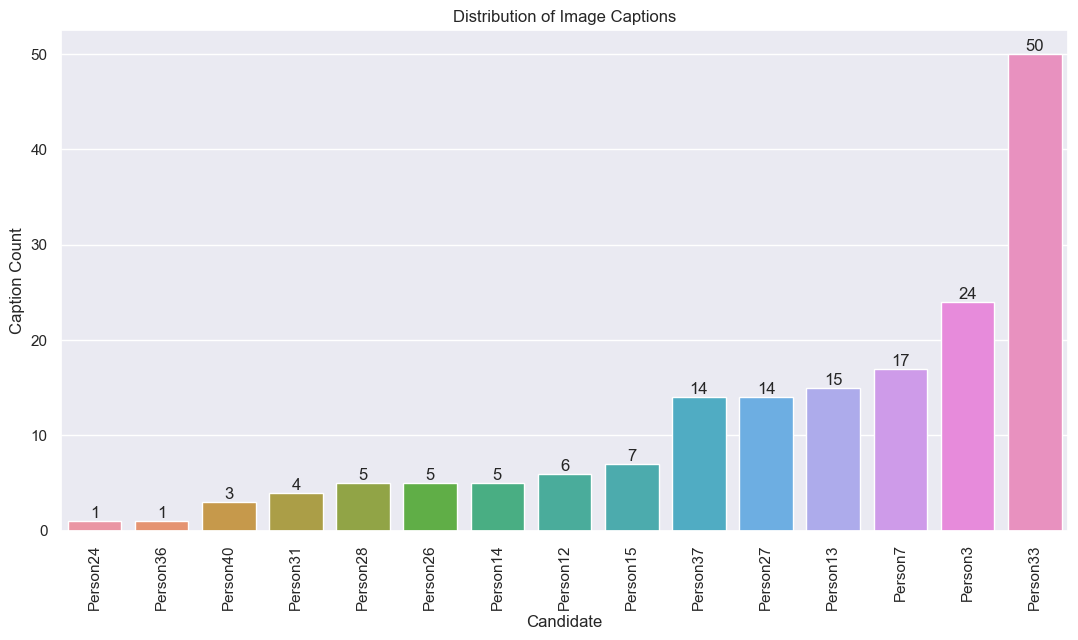

In [49]:
sns.set(rc={"figure.figsize":(13, 6.5)})
captionseries = pd.Series(captiondistribution).sort_values()
ax1 = sns.barplot(x=captionseries[captionseries != 0].index, y=captionseries[captionseries != 0])
ax1.set(xlabel="Candidate", ylabel="Caption Count", title="Distribution of Image Captions")
ax1.tick_params(axis='x', rotation=90)
for i in ax1.containers:
    ax1.bar_label(i,)
plt.show()

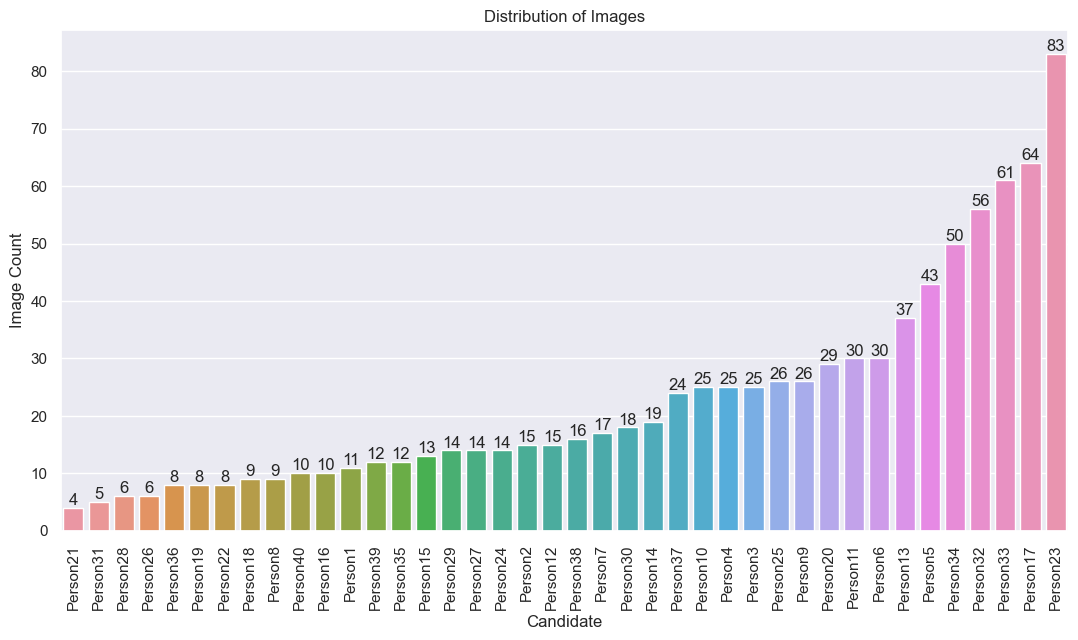

In [50]:
jpgseries = pd.Series(jpgdistribution).sort_values()
ax2 = sns.barplot(x=jpgseries.index, y=jpgseries)
ax2.set(xlabel="Candidate", ylabel="Image Count", title="Distribution of Images")
ax2.tick_params(axis='x', rotation=90)
for i in ax2.containers:
    ax2.bar_label(i,)
plt.show()

In [51]:
owned_objs_combined = {}

for k in owned_objs_jpg.keys():
    owned_objs_combined[k] = owned_objs_txt[k].union(owned_objs_jpg[k]).union(owned_objs_capt[k])

print(owned_objs_combined)

{'Person1': {'yellowBalloon'}, 'Person10': {'cactusPaper', 'partyFavor', 'legoBracelet', 'glassBead', 'stickerBox', 'trophy'}, 'Person11': {'trophy', 'vancouverCards'}, 'Person12': {'yellowBag', 'legoBracelet', 'hairClip', 'cactusPaper', 'noisemaker', 'pumpkinNotes', 'voiceRecorder'}, 'Person13': {'cupcakePaper', 'legoBracelet', 'birdCall', 'blueSunglasses', 'miniCards', 'brownDie', 'paperPlate', 'trophy', 'carabiner'}, 'Person14': {'pinkCandle', 'gyroscope', 'miniCards', 'brownDie', 'canadaPencil', 'pumpkinNotes', 'glassBead', 'cloudSign'}, 'Person15': {'sign', 'noisemaker', 'hairRoller', 'birdCall', 'pinkEraser', 'voiceRecorder'}, 'Person16': {'yellowBalloon'}, 'Person17': {'voiceRecorder', 'legoBracelet', 'glassBead', 'yellowBalloon', 'brownDie'}, 'Person18': {'lavenderDie', 'giftBag', 'eyeball'}, 'Person19': {'gClamp', 'paperPlate'}, 'Person2': {'spiderRing', 'partyFavor', 'glassBead', 'brownDie'}, 'Person20': {'trophy'}, 'Person21': set(), 'Person22': {'canadaPencil', 'blueSunglas

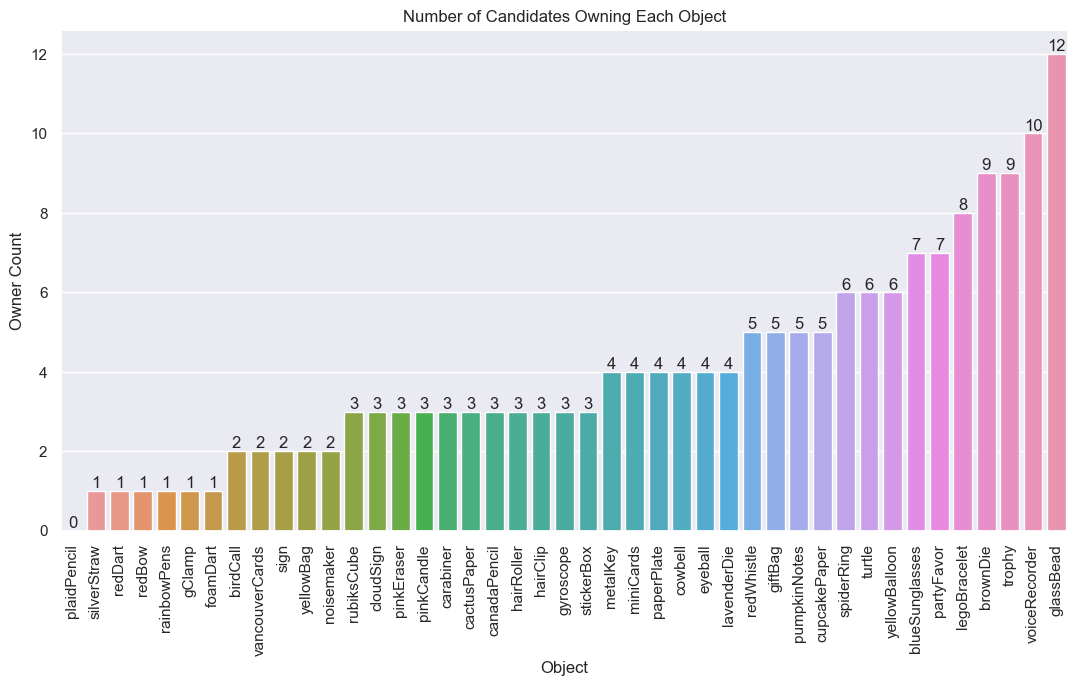

In [58]:
owner_count_by_obj = pd.Series({k:len(v) for k,v in obj_owners_combined.items()}).sort_values()
ax3 = sns.barplot(x=owner_count_by_obj.index, y=owner_count_by_obj)
ax3.set(xlabel="Object", ylabel="Owner Count", title="Number of Candidates Owning Each Object")
ax3.tick_params(axis='x', rotation=90)
for i in ax3.containers:
    ax3.bar_label(i,)
plt.show()

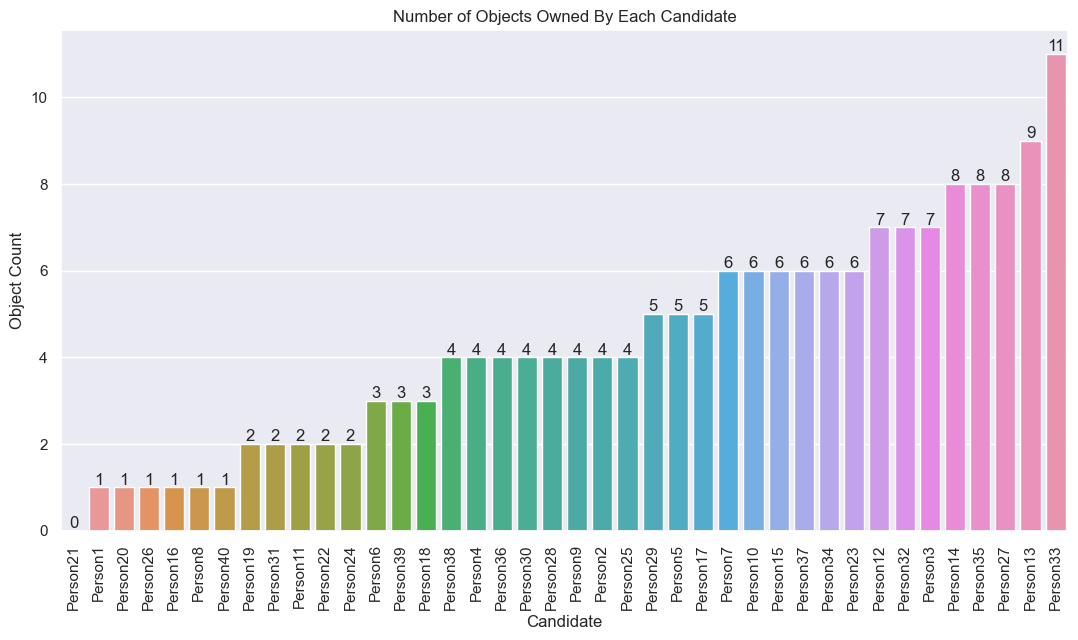

In [59]:
obj_count_by_owner = pd.Series({k:len(v) for k,v in owned_objs_combined.items()}).sort_values()
ax4 = sns.barplot(x=obj_count_by_owner.index, y=obj_count_by_owner)
ax4.set(xlabel="Candidate", ylabel="Object Count", title="Number of Objects Owned By Each Candidate")
ax4.tick_params(axis='x', rotation=90)
for i in ax4.containers:
    ax4.bar_label(i,)
plt.show()

In [60]:
obj_owners_combined_txt = {}

for k in obj_names:
    obj_owners_combined_txt[k] = obj_owners_txt[k].union(obj_owners_capt[k])

print(obj_owners_combined_txt)

{'birdCall': {'Person13', 'Person15'}, 'blueSunglasses': {'Person7', 'Person27', 'Person13', 'Person31'}, 'brownDie': {'Person7'}, 'cactusPaper': {'Person12'}, 'canadaPencil': {'Person35', 'Person14'}, 'carabiner': {'Person27', 'Person29'}, 'cloudSign': {'Person37'}, 'cowbell': {'Person35', 'Person28'}, 'cupcakePaper': {'Person13'}, 'eyeball': {'Person35'}, 'foamDart': set(), 'gClamp': set(), 'giftBag': set(), 'glassBead': {'Person29', 'Person3'}, 'gyroscope': {'Person35', 'Person37', 'Person14'}, 'hairClip': {'Person28', 'Person12'}, 'hairRoller': {'Person27', 'Person37', 'Person15'}, 'lavenderDie': {'Person29'}, 'legoBracelet': {'Person27', 'Person12', 'Person39'}, 'metalKey': set(), 'miniCards': {'Person14'}, 'noisemaker': {'Person12', 'Person15'}, 'paperPlate': {'Person37', 'Person13'}, 'partyFavor': set(), 'pinkCandle': {'Person35', 'Person27', 'Person14'}, 'pinkEraser': {'Person40', 'Person15'}, 'plaidPencil': set(), 'pumpkinNotes': {'Person27', 'Person3', 'Person12'}, 'rainbowPe